In [1]:
from fit.datamodules.tomo_rec import MNIST_TRecFITDM, Kanji_TRecFITDM, LoDoPaB_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram

from matplotlib import pyplot as plt

from skimage.transform import iradon

import torch

import numpy as np

from fit.utils import denormalize_FC, pol2cart, fft_interpolate

In [2]:
dm = MNIST_TRecFITDM(root_dir='./data/', batch_size=4, num_angles=7)

# dm = Kanji_TRecFITDM(root_dir='./data/Kanji/', batch_size=4, num_angles=33)

# dm = LoDoPaB_TRecFITDM(batch_size=4, gt_shape=111, num_angles=33)

dm.prepare_data()
dm.setup()

In [3]:
train_dl = dm.train_dataloader()

for sino, img  in train_dl.dataset.ds:
    break

In [4]:
train_dl = dm.train_dataloader()

for x, fbp, y, y_real, (mag_min, mag_max) in train_dl:
    break

In [5]:
# We have to convert angle and magnitude back to Fourier coefficients
x_fc = denormalize_FC(x, mag_min, mag_max)
y_fc = denormalize_FC(y, mag_min, mag_max)

In [6]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [7]:
# Computing the projection and target Fourier coefficient coordinates
srcx, srcy, src_flatten_order = get_polar_rfft_coords_sinogram(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                det_len=det_len)
dstx, dsty, dst_flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
target_shape = order.shape
print('Fourier Space Shape:', target_shape)

Fourier Space Shape: torch.Size([27, 14])


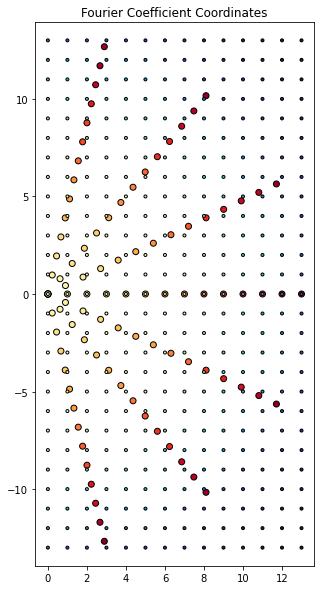

In [8]:
plt.figure(figsize=(5, 10))
plt.scatter(*pol2cart(srcx, srcy), marker='o', label='Projection Coordinates', 
            c=np.arange(srcx.shape[0]), cmap='YlOrRd', linewidth=1, edgecolor='black')
plt.scatter(*pol2cart(dstx, dsty), marker='.', label='Target Coordinates', c=np.arange(dstx.shape[0]), 
            cmap='YlGnBu', linewidth=1, edgecolor='black')

plt.axis('equal')
plt.title('Fourier Coefficient Coordinates');

In [9]:
fbp = iradon(sino.numpy().T, theta=np.rad2deg(-dm.gt_ds.get_ray_trafo().geometry.angles), circle=True,
                 output_size=dm.gt_shape).astype(np.float32).T

In [10]:
fc_interpolated = fft_interpolate(srcx, srcy, dstx, dsty, x_fc[0,src_flatten_order], 
                                   target_shape=target_shape, dst_flatten_order=dst_flatten_order)
rec_interpolated = np.roll(np.fft.irfftn(fc_interpolated, s=2*(dm.gt_shape,)), 2*(dm.gt_shape//2,), (0, 1))

In [11]:
y_fc_ = y_fc[0].numpy().flatten()[dst_flatten_order]
y_fc_[dst_flatten_order] = y_fc_.flatten()
y_target = np.roll(np.fft.irfftn(y_fc_.reshape(*target_shape), s=2*(dm.gt_shape,)), 2*(dm.gt_shape//2,), (0, 1))

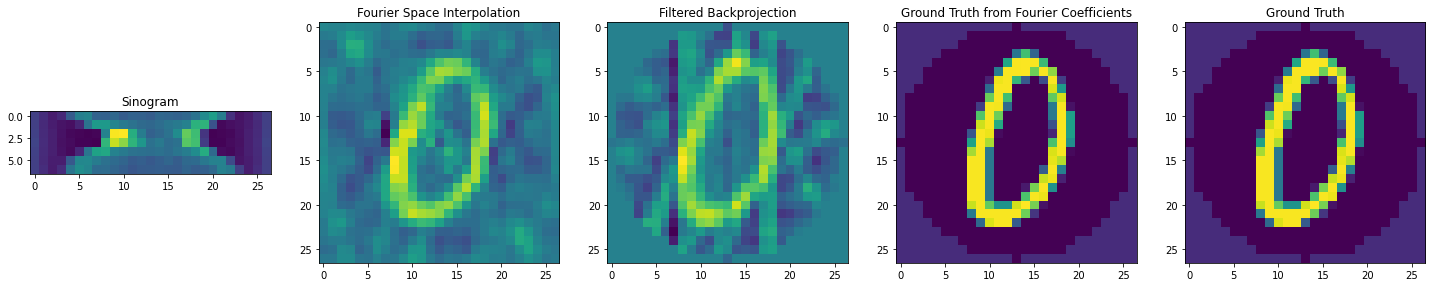

In [12]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(sino)
plt.title('Sinogram');
plt.subplot(1,5,2)
plt.imshow(rec_interpolated)
plt.title('Fourier Space Interpolation');
plt.subplot(1,5,3)
plt.imshow(fbp)
plt.title('Filtered Backprojection')
plt.subplot(1,5,4)
plt.imshow(y_target)
plt.title('Ground Truth from Fourier Coefficients');
plt.subplot(1,5,5)
plt.imshow(y_real[0])
plt.title('Ground Truth');